## Visualization: Grad-CAM ##

While deep learning has facilitated unprecedented accuracy in image classification, object detection, and image segmentation, one of their biggest problems is model interpretability, a core component in model understanding and model debugging.

In practice, deep learning models are treated as “black box” methods, and many times we have no reasonable idea as to:

* Where the network is “looking” in the input image
* Which series of neurons activated in the forward-pass during inference/prediction
* How the network arrived at its final output

That raises an interesting question — how can you trust the decisions of a model if you cannot properly validate how it arrived there?

To help deep learning practitioners visually debug their models and properly understand where it’s “looking” in an image, Selvaraju et al. created Gradient-weighted Class Activation Mapping, or more simply, Grad-CAM:

"Grad-CAM uses the gradients of any target concept (say logits for “dog” or even a caption), flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.”

Using Grad-CAM, we can visually validate where our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns.

In [1]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as pl

# We will use a library created by Jacob Gildenblat 
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of plots
plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.fileutils import FileOP
from dentexmodel.torchdataset import DatasetFromDF, load_and_process_image

print(f'dentexmodel package version:  {dm.__version__}')

dentexmodel package version:  0.0.post1.dev163+g9fa083d.d20240224


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

# Lets run inference on the CPU
device = torch.device("cpu")
torch.set_float32_matmul_precision(precision='high')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [3]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays')
cropped_image_dir = os.path.join(image_dir, 'crop')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')
image_output_dir = os.path.join(output_dir, 'gradcam')
Path(image_output_dir).mkdir(parents=True, exist_ok=True)

data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

### Load the test data ###

In [4]:
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

image_id      file_name  image_number                                          file_path quadrant position     label  cl   area                                               bbox            box_name  annotations                                           box_file  im_width  im_height dataset
0       272  train_191.png           191  /app/data/dentex/dentex_classification/quadran...        1        8  Impacted   0  39275                       [677.0, 446.0, 276.0, 207.0]  train_191_1435_1_8            9  /app/data/dentex/dentex_classification/quadran...       276        207   train
1       600  train_418.png           418  /app/data/dentex/dentex_classification/quadran...        1        7    Caries   1  34312  [790.2912621359224, 372.81553398058253, 141.74...  train_418_3035_1_7            9  /app/data/dentex/dentex_classification/quadran...       142        310   train

In [5]:
# Create the class dictionary from the data frame
label_col = 'cl'
label_list = sorted(list(data_df['label'].unique()))
label_cl = [data_df.loc[data_df['label'] == label, label_col].values[0] for label in label_list]
label_dict = dict(zip(label_cl, label_list))
display(label_dict)

test_df = data_df.loc[data_df['dataset'] == 'test']

test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df['label'].value_counts())
print()
display(test_df.head())

{1: 'Caries', 3: 'Deep Caries', 0: 'Impacted', 2: 'Periapical Lesion'}

Found 120 samples in the test set.



label
Deep Caries          30
Impacted             30
Periapical Lesion    30
Caries               30
Name: count, dtype: int64

image_id      file_name  image_number                                          file_path quadrant position        label  cl   area                                               bbox            box_name  annotations                                           box_file  im_width  im_height dataset
47        360  train_248.png           248  /app/data/dentex/dentex_classification/quadran...        3        6  Deep Caries   3  15680                      [1763.0, 617.0, 125.0, 170.0]  train_248_1898_3_6            4  /app/data/dentex/dentex_classification/quadran...       125        170    test
83         17  train_564.png           564  /app/data/dentex/dentex_classification/quadran...        1        8     Impacted   0   8873                    [448.25, 282.0, 101.25, 128.75]   train_564_107_1_8           10  /app/data/dentex/dentex_classification/quadran...       102        129    test
196       520  train_420.png           420  /app/data/dentex/dentex_classification/quadran...        4        8  Deep Caries   3  26130  [659.1836734693877, 746.7755102040816, 206.122...  train_420_2692_4_8           11  /app/data/dentex/dentex_classification/quadran...       206        196    test
233       633   train_53.png            53  /app/data/dentex/dentex_classification/quadran...        2        8     Impacted   0  22225                      [2210.0, 418.0, 176.0, 181.0]   train_53_3163_2_8           10  /app/data/dentex/dentex_classification/quadran...       176        181    test
256       370  train_631.png           631  /app/data/dentex/dentex_classification/quadran...        4        8     Impacted   0  33393  [686.5853658536585, 763.4146341463414, 175.609...  train_631_1951_4_8            2  /app/data/dentex/dentex_classification/quadran...       175        281    test

In [6]:
# Create a pytorch data set from the data frame
# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224
batch_size = 32
num_classes = 4

# We need the same normalization as we used for training
val_transform = alb.Compose([alb.Resize(im_size, im_size),
                             alb.Normalize(mean=ImageData().image_net_mean, 
                                           std=ImageData().image_net_std)])

# Create the PyTorch dataset
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col=label_col,
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)
# Create a data loader
dl = DataLoader(test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

### Run model on the test set ###

In [13]:
from dentexmodel.models.toothmodel_fancy import ToothModel
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel_fancy_45.ckpt'

# Let's see if we have a saved checkpoint
# The previous training notebook should have the defined model name
model_name = 'FancyLR'
model_version = 1

# The latest checkpoint should be here
checkpoint_dir = os.path.join(model_dir, 
                              model_name,
                              f'version_{model_version}',
                              'checkpoints')

last_checkpoint = glob.glob(os.path.join(checkpoint_dir, 'last.ckpt'))
if len(last_checkpoint) > 0:
    print(f'Using checkpoint file "last.ckpt" in {checkpoint_dir}.')
    checkpoint_file = last_checkpoint[0]
else:
    print(f'Last checkpoint file "last.ckpt" not found in {checkpoint_dir}.')
    print(f'Downloading checkpoint from {link}')
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    checkpoint_file = FileOP().download_from_url(url=link, download_dir=checkpoint_dir)

Last checkpoint file "last.ckpt" not found in /app/data/model/FancyLR/version_1/checkpoints.
Created .ckpt file.


In [14]:
model = ToothModel.load_from_checkpoint(checkpoint_file,
                                        test_dataset=test_dataset, 
                                        map_location=device,
                                        batch_size=batch_size,
                                        num_classes=num_classes,
                                        num_workers=1)

In [15]:
# Create one batch of data
image_batch, label_batch = next(iter(dl))

max_pixel_value = 1
image_mean = torch.tensor(np.multiply(ImageData().image_net_mean, max_pixel_value))
image_std = torch.tensor(np.multiply(ImageData().image_net_std, max_pixel_value))

# Create a list of images from the input batch
torch_image_list = [image_batch[i] for i in range(batch_size)]

# Un-normalize the images and clip values [0, 1]
image_list = [torch.permute(torch_image, (1, 2, 0)) for torch_image in torch_image_list]
image_list = [(torch.mul(image, image_std) + image_mean).detach().numpy() for image in image_list]
image_list = [np.clip(image, 0, max_pixel_value) for image in image_list]

In [16]:
# Run the batch through the model
outputs = model(image_batch)
predicted_labels = torch.argmax(outputs, dim=1).detach().numpy()
outputs = outputs.detach().numpy()
true_labels = label_batch.numpy()

# Get the image names from the data frame
true_labels_df = test_df['cl'].values[:batch_size]
true_labels_names_df = test_df['label'].values[:batch_size]
file_names = test_df['file_name'].values[:batch_size]

# Print the output_classes
print(f'Ground truth labels for batch: {true_labels}')
print(f'Labels from data frame:        {true_labels_df}')
print(f'Model predictions for batch:   {predicted_labels}')

Ground truth labels for batch: [3 0 3 0 0 2 2 1 2 2 0 2 3 2 3 2 0 2 2 1 2 2 3 3 0 1 1 3 1 1 2 1]
Labels from data frame:        [3 0 3 0 0 2 2 1 2 2 0 2 3 2 3 2 0 2 2 1 2 2 3 3 0 1 1 3 1 1 2 1]
Model predictions for batch:   [3 0 3 0 1 2 1 1 1 1 0 1 1 1 3 2 0 2 1 1 2 1 3 1 1 1 1 2 1 1 1 1]


### Create the Grad-CAM visualizations for the image batch ###

In [17]:
# Get the PyTorch model out of the lightning instance
torch_model = model.model

# Target layers
target_layers = [torch_model.layer4[-1]]
print(target_layers)

# Input tensor
input_tensor = image_batch

# Predicted labels
targets = [ClassifierOutputTarget(t) for t in predicted_labels]

# Instantiate the GradCAM class
with GradCAM(model=torch_model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=image_batch, targets=targets, aug_smooth=True, eigen_smooth=True)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


### Overlay images ###

Image 1 of 32
train_248



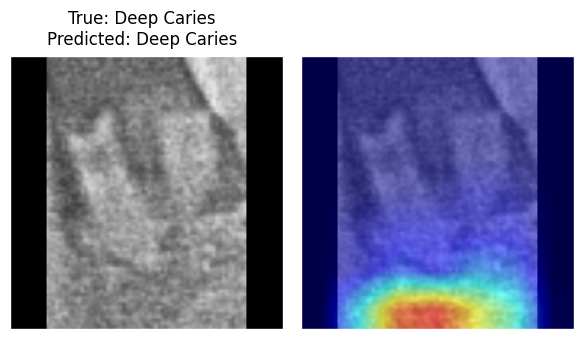

Image 2 of 32
train_564



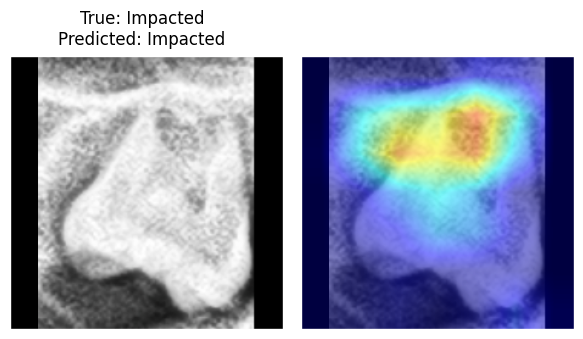

Image 3 of 32
train_420



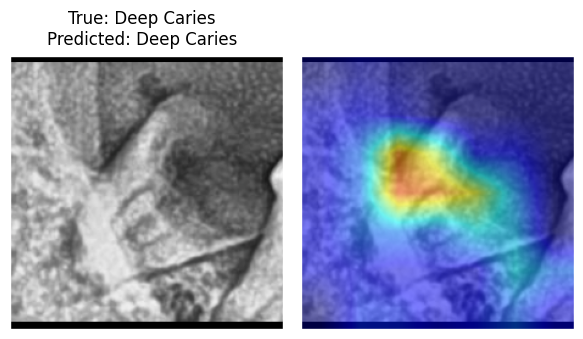

Image 4 of 32
train_53



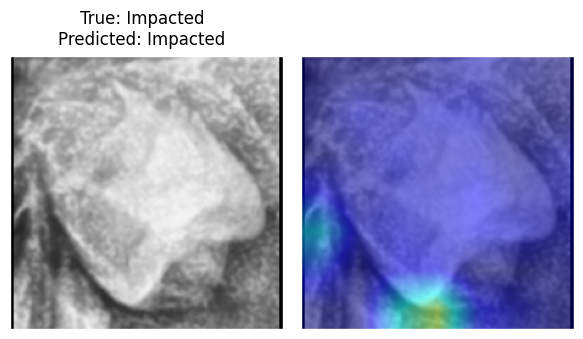

Image 5 of 32
train_631



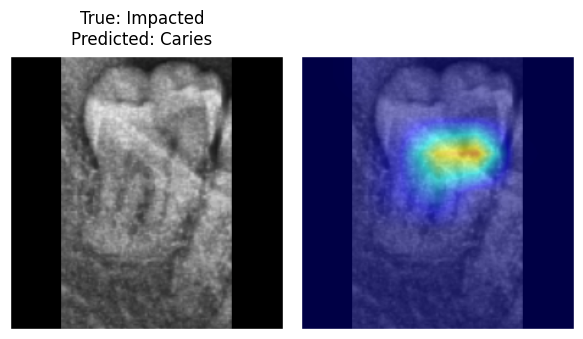

Image 6 of 32
train_324



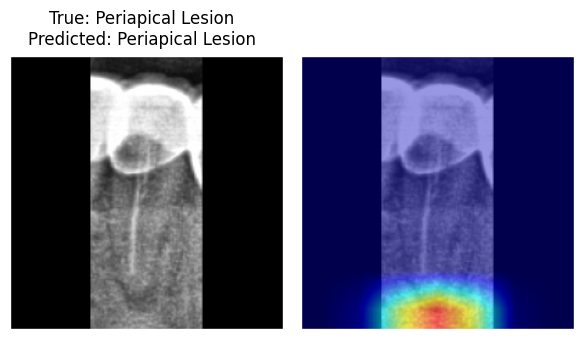

Image 7 of 32
train_523



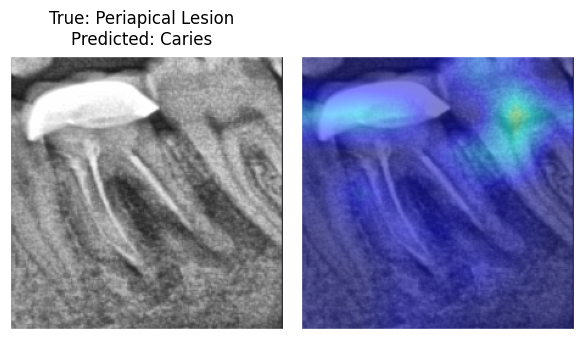

Image 8 of 32
train_628



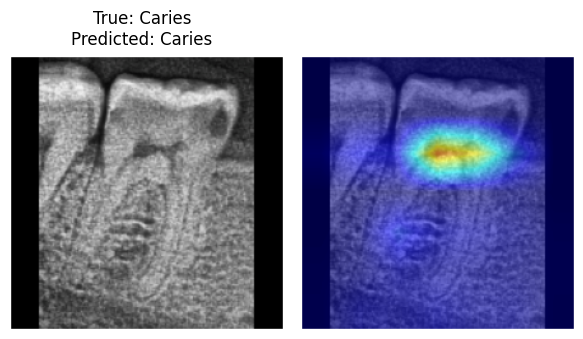

Image 9 of 32
train_510



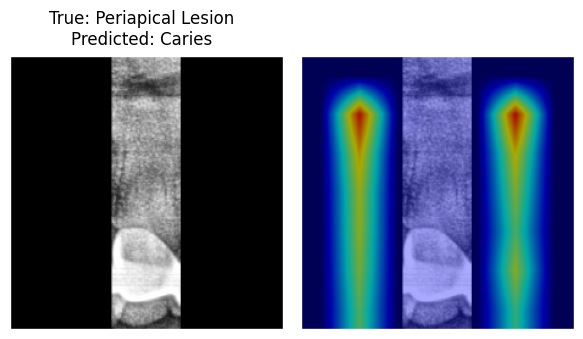

Image 10 of 32
train_233



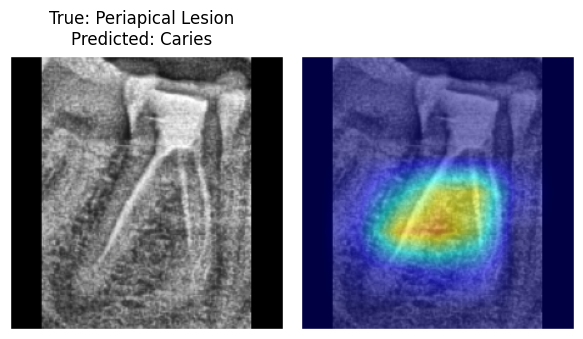

Image 11 of 32
train_300



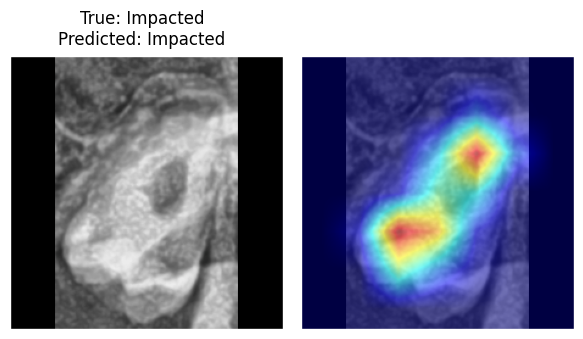

Image 12 of 32
train_168



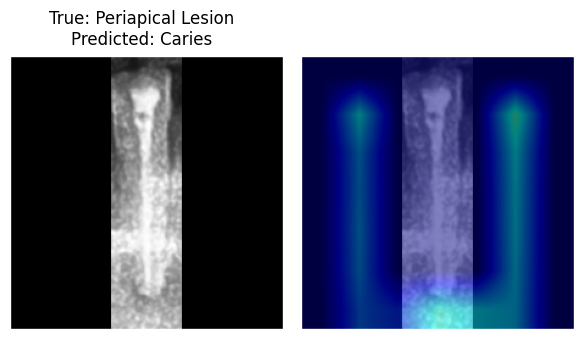

Image 13 of 32
train_590



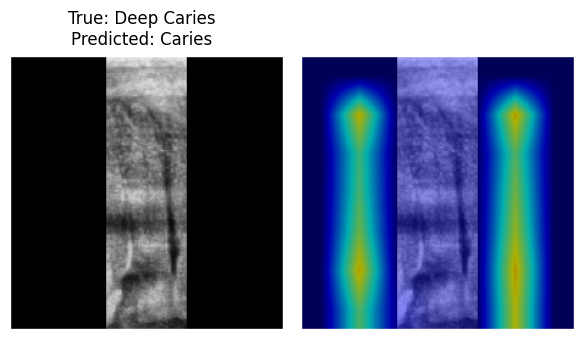

Image 14 of 32
train_479



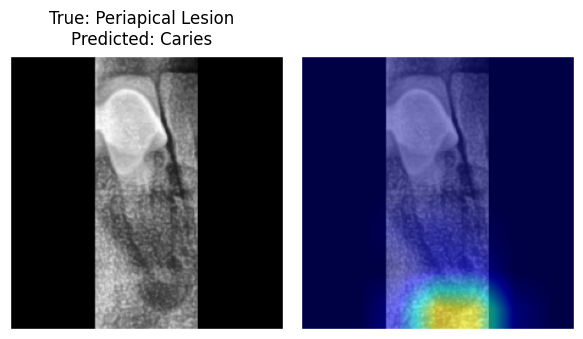

Image 15 of 32
train_592



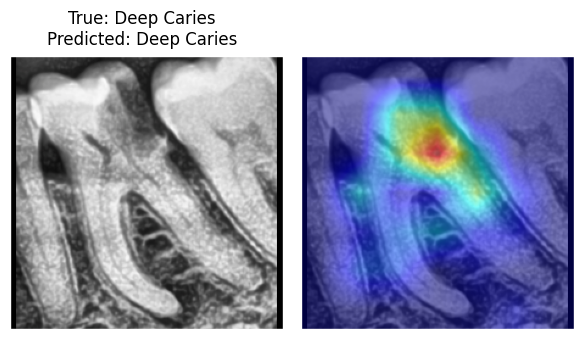

Image 16 of 32
train_420



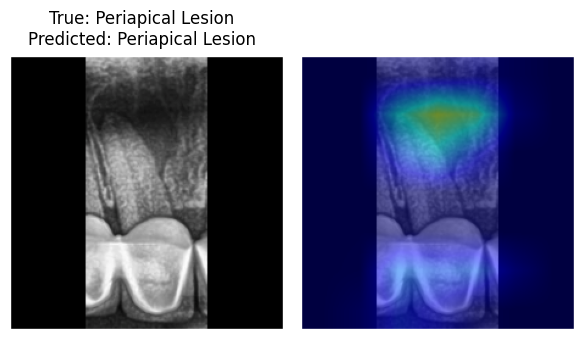

Image 17 of 32
train_17



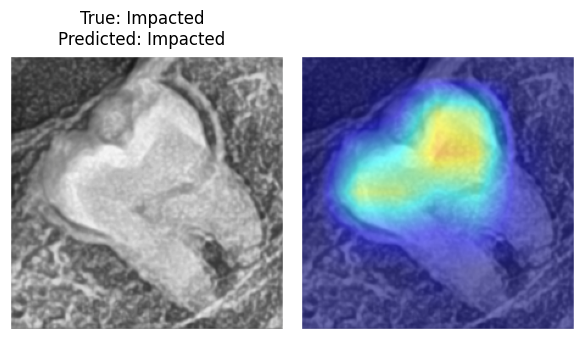

Image 18 of 32
train_673



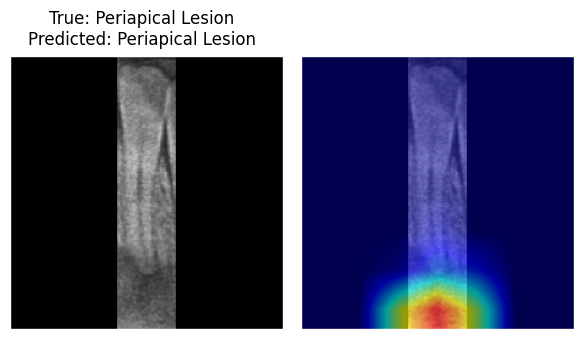

Image 19 of 32
train_349



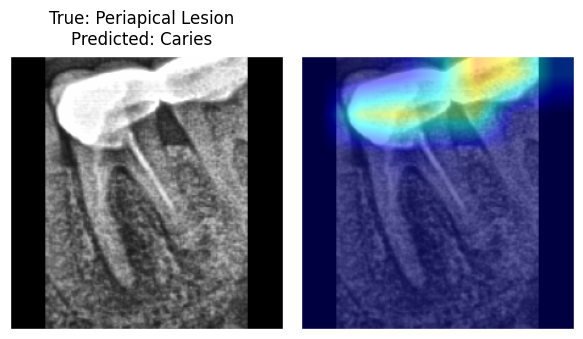

Image 20 of 32
train_675



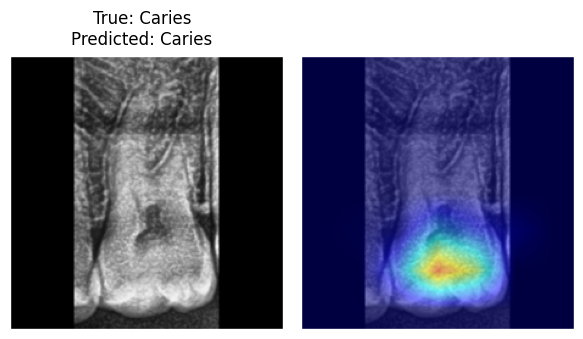

Image 21 of 32
train_323



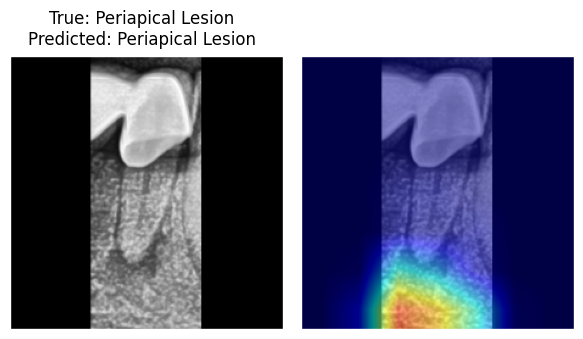

Image 22 of 32
train_510



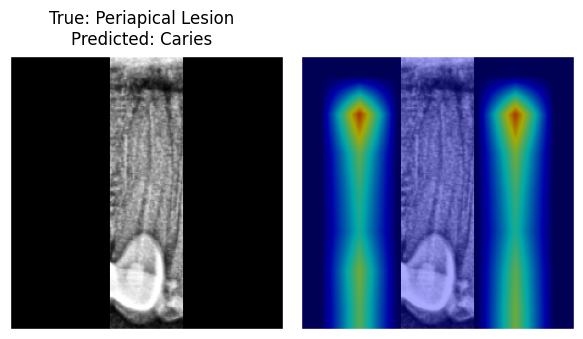

Image 23 of 32
train_244



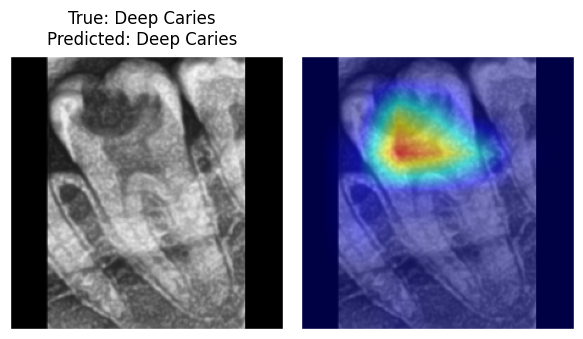

Image 24 of 32
train_471



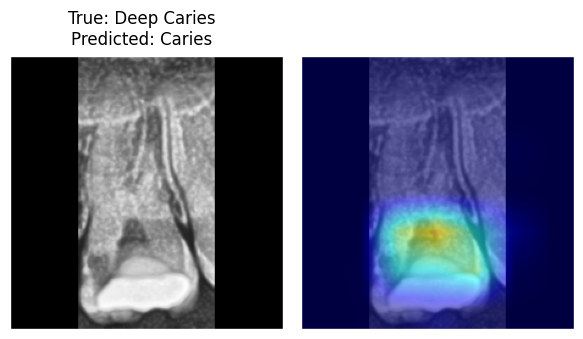

Image 25 of 32
train_246



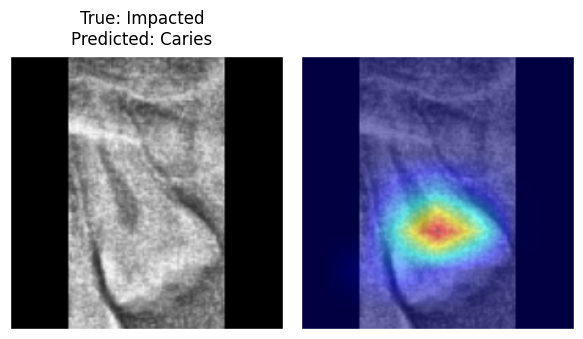

Image 26 of 32
train_341



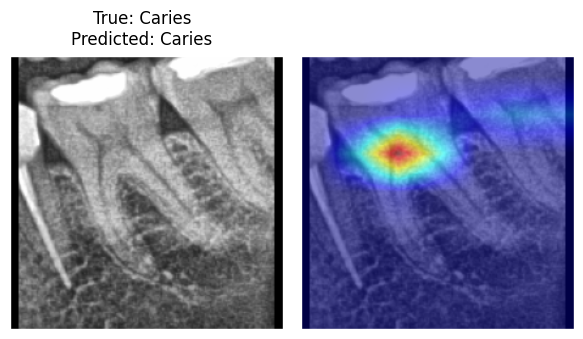

Image 27 of 32
train_49



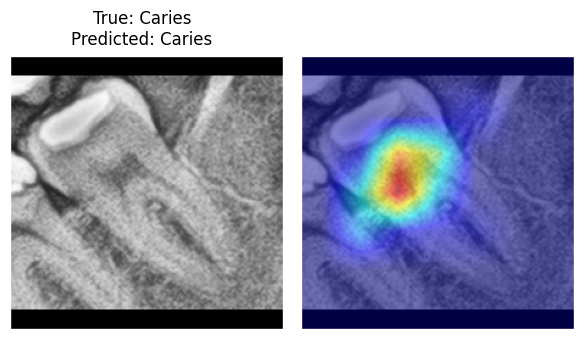

Image 28 of 32
train_655



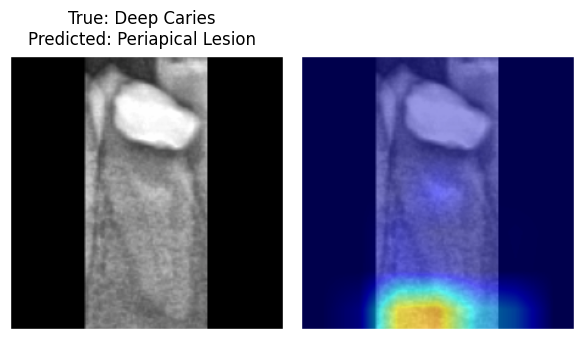

Image 29 of 32
train_135



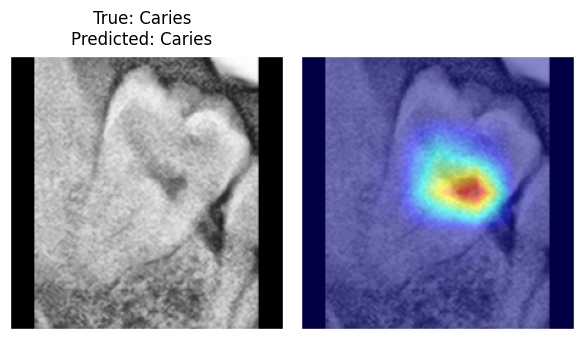

Image 30 of 32
train_647



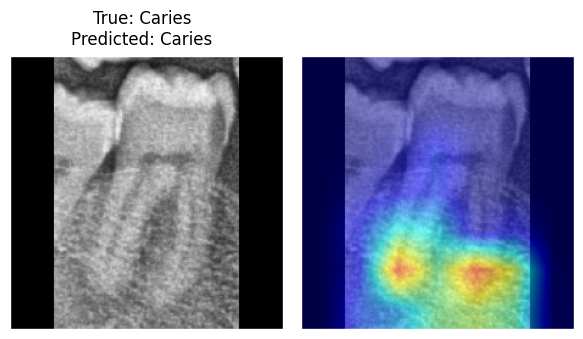

Image 31 of 32
train_550



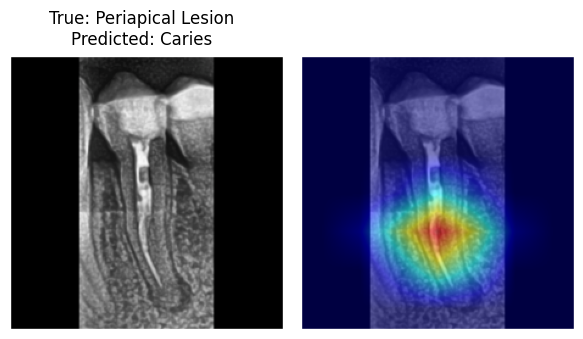

Image 32 of 32
train_168



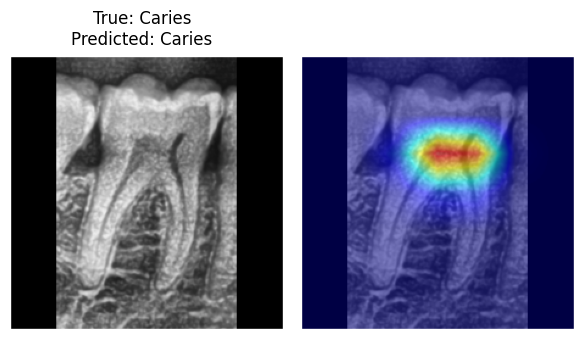

In [18]:
# Create the overlay
# RGB input image
idx = 3
img = image_list[idx]

for idx, img in enumerate(image_list):

    print(f'Image {idx +1} of {len(image_list)}')
    image_name = os.path.splitext(file_names[idx])[0]
    print(image_name)
    print()
    
    vis = show_cam_on_image(img=img, 
                            mask=grayscale_cam[idx], 
                            use_rgb=True, 
                            image_weight=0.5)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
    
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(vis)
    for axi in ax:
        axi.set(xticks=[], yticks=[])
    
    fig.suptitle(
        (f'True: {label_dict.get(true_labels[idx])}\n'
         f'Predicted: {label_dict.get(predicted_labels[idx])}'), x=0.25, fontsize=SMALL_SIZE)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.999)

    # Save the image
    output_file_name = f'{image_name}_gradcam.png'
    output_file = os.path.join(image_output_dir, output_file_name)
    plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()